In [204]:
import jax
import netket as nk
import numpy as np
from netket.operator.spin import sigmax,sigmaz, sigmap, sigmam
import time
from scipy.sparse.linalg import eigsh
import jax.numpy as jnp
import matplotlib.pyplot as plt

def ABC(L):
    B = {}
    A = {0}
    C = {}
    for i in range (1, L):
        B[i] = [i+j*(L-1) for j in range(i+1)]
    for i in range (L, 2*L-2):
        B[i] = [(i-L+1)*L+j*(L-1) for j in range(1, 2*L-i)]
    for i in B:
        if i!=1:
            B[i]+=B[i-1]
            B[i].sort()
    for i in B:
        C[i] = set(range(L**2))-set(B[i])-A
    return A, B, C

def ABC_complete(L, pos_A):
    B = {}
    A = {pos_A}
    C = {}
    y0 = tuple(A)[0]//L
    x0 = tuple(A)[0]%L

    for y in range (L):
        for x in range (L):
            if y*L+x> tuple(A)[0]:
                d = np.abs(y-y0)+np.abs(x-x0)
                if d not in B:
                    B[d] = [y*L+x]
                else:
                    B[d].append(y*L+x)
    B = dict(sorted(B.items()))
    C = dict(sorted(C.items()))
    for i in B:
        if i!=1:
            B[i] += B[i-1]
        B[i].sort()
    B.popitem()     #remove the last element
    for i in B:
        C[i] = set(range(tuple(A)[0]+1, L**2))-set(B[i])
    B = dict(sorted(B.items()))
    C = dict(sorted(C.items()))
    return A,B,C

def cmi_traceout(prob_exact, L):
    cmi = [[] for i in range(L*(L-2))]
    for i in range (L*(L-2)):
        A,B,C = ABC_complete(L, i)
        p_ab = prob_exact.sum(axis=tuple(set(range(L**2))-A))+1e-30
        p_bc = prob_exact.sum(axis=tuple(set(range(i)).union(A)))+1e-30
        p_abc = prob_exact.sum(axis=tuple(set(range(i))))+1e-30
        cmi[i].append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(p_abc*np.log(p_abc)))
        for j in B:
            tmp = 0
            p_ab = prob_exact.sum(axis=tuple(set(range(i)).union(C[j])))
            tmp += np.sum(p_ab*np.log(p_ab))+1e-30
            p_bc = prob_exact.sum(axis=tuple(set(range(i)).union(A)))
            tmp += np.sum(p_bc*np.log(p_bc))+1e-30
            tmp -= np.sum(p_abc*np.log(p_abc))
            p_b = prob_exact.sum(axis=tuple(set(range(i)).union(C[j].union(A))))+1e-30
            tmp -= np.sum(p_b*np.log(p_b))
            cmi[i].append(-tmp)

    return cmi

def count_diff_ones_zeros(n):
    # Generating all combinations from 0^n to 1^n
    combinations = np.array([np.binary_repr(i, width=n) for i in range(2**n)])

    # Counting the difference between the number of 1s and 0s in each combination
    diff_counts = np.array([combination.count('1') - combination.count('0') for combination in combinations])

    return diff_counts

def cmi_(prob_exact, L):  #cmi for the first spin as |A|
    A,B,C = ABC(L)
    cmi = []
    p_ab = prob_exact.sum(axis=tuple(set(range(L**2))-A))+1e-30
    p_bc = prob_exact.sum(axis=tuple(A))+1e-30
    cmi.append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(prob_exact*np.log(prob_exact+1e-30)))
    for i in B:
        tmp = 0
        p_ab = prob_exact.sum(axis=tuple(C[i]))
        tmp += np.sum(p_ab*np.log(p_ab))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A))
        tmp += np.sum(p_bc*np.log(p_bc))+1e-30
        tmp -= np.sum(prob_exact*np.log(prob_exact+1e-30))
        p_b = prob_exact.sum(axis=tuple(C[i].union(A)))+1e-30
        tmp -= np.sum(p_b*np.log(p_b))
        cmi.append(-tmp)
    return np.array(cmi)
def correlation_all(prob_exact, L):   #correlation function respect to all spins and then taking average
    corr = [[] for i in range(2*(L-1)+1)]
    mean_corr = [[] for i in range(2*(L-1)+1)]
    var_corr = [[] for i in range(2*(L-1)+1)]
    for i in range(L**2):
        for j in range(i+1, L**2):
            y0 = i//L
            x0 = i%L
            y1 = j//L
            x1 = j%L
            p_spin = prob_exact.sum(axis=tuple(set(range(L**2))-set([i, j])))+1e-30
            p_spin0 = p_spin.sum(axis=0)
            p_spin1 = p_spin.sum(axis=1)
            cor = (p_spin[0, 0]+p_spin[1, 1]-p_spin[0, 1]-p_spin[1, 0])-(p_spin0[0]-p_spin0[1])*(p_spin1[0]-p_spin1[1])
            corr[np.abs(y1-y0)+np.abs(x1-x0)].append(cor)
        p_spin = prob_exact.sum(axis=tuple(set(range(L**2))-set([i])))+1e-30
        cor = (p_spin**2).sum()-(p_spin[0]-p_spin[1])**2
        corr[0].append(cor)
    for i in range(len(corr)):
        mean_corr[i] = np.array(corr[i]).mean()
        var_corr[i] = np.array(corr[i]).var()
    return np.array(mean_corr), np.array(var_corr)

def correlation_one(prob_exact, L):    # correlation function respect to [0, 0]
    corr = [[] for i in range(2*(L-1)+1)]
    mean_corr = [[] for i in range(2*(L-1)+1)]
    var_corr = [[] for i in range(2*(L-1)+1)]
    for i in range(1, L**2):
        y0 = 0
        x0 = 0
        y1 = i//L
        x1 = i%L
        p_spin = prob_exact.sum(axis=tuple(set(range(L**2))-set([0, i])))+1e-30
        p_spin0 = p_spin.sum(axis=0)
        p_spin1 = p_spin.sum(axis=1)
        cor = (p_spin[0, 0]+p_spin[1, 1]-p_spin[0, 1]-p_spin[1, 0])-(p_spin0[0]-p_spin0[1])*(p_spin1[0]-p_spin1[1])
        corr[np.abs(y1-y0)+np.abs(x1-x0)].append(cor)
    p_spin = prob_exact.sum(axis=tuple(set(range(L**2))-set([0])))+1e-30
    cor = (p_spin**2).sum()-(p_spin[0]-p_spin[1])**2
    corr[0].append(cor)
    for i in range(len(corr)):
        mean_corr[i] = np.array(corr[i]).mean()
        var_corr[i] = np.array(corr[i]).var()
    return np.array(mean_corr), np.array(var_corr)
L = 4
N = L*L
periodic = False
hi = nk.hilbert.Spin(s=1 / 2, N =  N)

B_ = [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]



for B_field in B_ :
    H = -sum([sigmaz(hi, y*L+x)*sigmaz(hi, (y+1)*L+x) for y in range(L-1) for x in range(L)])  #up-down
    H -= sum([sigmaz(hi, y*L+x)*sigmaz(hi, y*L+x+1) for y in range(L) for x in range(L-1)]) #left-right
    H -= B_field*sum([sigmax(hi, y*L+x) for y in range(L) for x in range(L)]) # B

    if (periodic == True):
    #periodic boundary conditions
        H-= sum([sigmaz(hi, x)*sigmaz(hi, (L-1)*L+x) for x in range(L)]) # last row - first row
        H-= sum([sigmaz(hi, y*L)*sigmaz(hi, y*L+L-1) for y in range(L)]) # last column - first column

    sp_h = H.to_sparse()
    eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
    print("eigenvalues with scipy sparse B="+str(B_field) +":", eig_vals)

    prob_exact = eig_vecs[:,0]**2
    mag = np.sum(prob_exact*count_diff_ones_zeros(L**2))
    shape = (2,) * (L**2)
    prob_exact = prob_exact.reshape(*shape)
    mean_corr, var_corr = correlation_all(prob_exact, L)
    cmi = cmi_(prob_exact, L)
    cmi_all = cmi_traceout(prob_exact, L)
    np.save("result/2DTFIM/gap_2DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", np.array(eig_vals[1]-eig_vals[0]))
    np.save("result/2DTFIM/cmi_2DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", cmi)
    np.save("result/2DTFIM/mean_corr_2DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", mean_corr)
    np.save("result/2DTFIM/var_corr_2DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", var_corr)
    np.save("result/2DTFIM/cmi_traceout_2DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", cmi_all)
    np.save("result/2DTFIM/mag_2DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", mag)

eigenvalues with scipy sparse B=1.0: [-30.35283724 -30.35283144]


C:\Users\Administrator\anaconda3\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


eigenvalues with scipy sparse B=1.25: [-31.69368776 -31.69352345]
eigenvalues with scipy sparse B=1.5: [-33.35073532 -33.34848156]
eigenvalues with scipy sparse B=1.75: [-35.34103383 -35.32306301]
eigenvalues with scipy sparse B=2.0: [-37.7007506  -37.60971898]
eigenvalues with scipy sparse B=2.25: [-40.4781031 -40.1759844]
eigenvalues with scipy sparse B=2.5: [-43.65238848 -42.96764764]
eigenvalues with scipy sparse B=2.75: [-47.10526246 -45.92685043]
eigenvalues with scipy sparse B=3.0: [-50.72270464 -49.00608785]


In [205]:
import numpy as np

def count_diff_ones_zeros(n):
    # Generating all combinations from 0^n to 1^n
    combinations = np.array([np.binary_repr(i, width=n) for i in range(2**n)])

    # Counting the difference between the number of 1s and 0s in each combination
    diff_counts = np.array([combination.count('1') - combination.count('0') for combination in combinations])

    return diff_counts

# Example for n = 3
count_diff_ones_zeros(4)


array([-4, -2, -2,  0, -2,  0,  0,  2, -2,  0,  0,  2,  0,  2,  2,  4])

In [206]:
import numpy as np
import matplotlib.pyplot as plt
# Dictionary to store the loaded arrays
L = 4
N = L*L
periodic = False

cmi = {}
mean_corr= {}
var_corr = {}
gap = {}
cmi_traceout = {}
mag = {}
# Looping through the values and loading each file
for b in B_:
    filename = f"result/2DTFIM/cmi_2DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    cmi[b] = np.load(filename)
    filename = f"result/2DTFIM/mean_corr_2DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    mean_corr[b] = np.load(filename)
    filename = f"result/2DTFIM/var_corr_2DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    var_corr[b] = np.load(filename)
    filename = f"result/2DTFIM/gap_2DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    gap[b] = np.load(filename)
    filename = f"result/2DTFIM/cmi_traceout_2DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    cmi_traceout[b] = np.load(filename, allow_pickle=True)
    filename = f"result/2DTFIM/mag_2DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    mag[b] = np.load(filename)


In [207]:
print(mag)

{1.0: array(-1.37247902e-08), 1.25: array(-4.09850465e-09), 1.5: array(5.59352564e-10), 1.75: array(-1.85238491e-11), 2.0: array(-4.35207426e-14), 2.25: array(8.46878123e-13), 2.5: array(-1.05160325e-12), 2.75: array(-3.79252185e-13), 3.0: array(4.4408921e-15)}


In [208]:
cmi_length = []
err_cmi_length =[]
corre_length = []
err_corre_length = []
cmi_length_traceout = [[] for i in range (len(B_))]
err_cmi_length_traceout = [[] for i in range (len(B_))]

for i in B_:
    df = len(cmi[i])-2
    (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi[i])), -np.log(cmi[i]), 1, full=True)
    mean_x = np.mean(np.arange(len(cmi[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi[i])) - mean_x)**2))
    cmi_length.append(cmi_len)
    err_cmi_length.append(err)

    (corr_len, b2), residuals, _, _, _ = np.polyfit(np.arange(len(mean_corr[i])), -np.log(mean_corr[i]), 1, full=True)
    mean_x = np.mean(np.arange(len(mean_corr[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(mean_corr[i])) - mean_x)**2))
    corre_length.append(corr_len)
    err_corre_length.append(err)

    for j in range(len(cmi_traceout[i])):
        df = len(cmi_traceout[i][j])-2
        (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi_traceout[i][j])), -np.log(cmi_traceout[i][j]), 1, full=True)
        mean_x = np.mean(np.arange(len(cmi_traceout[i][j])))
        err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi_traceout[i][j])) - mean_x)**2))
        cmi_length_traceout[B_.index(i)].append(cmi_len)
        err_cmi_length_traceout[B_.index(i)].append(err)



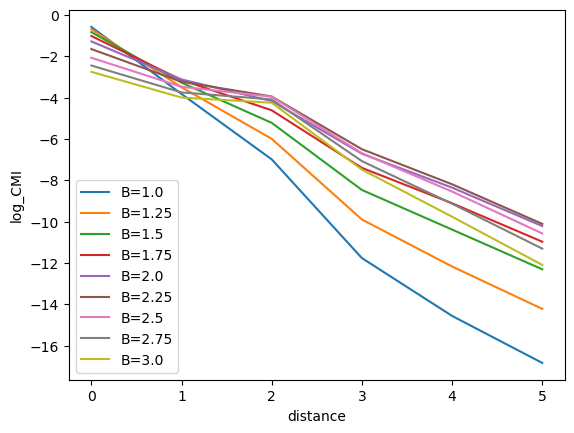

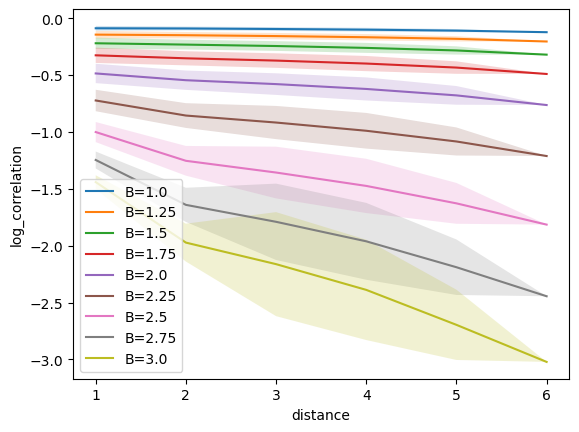

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


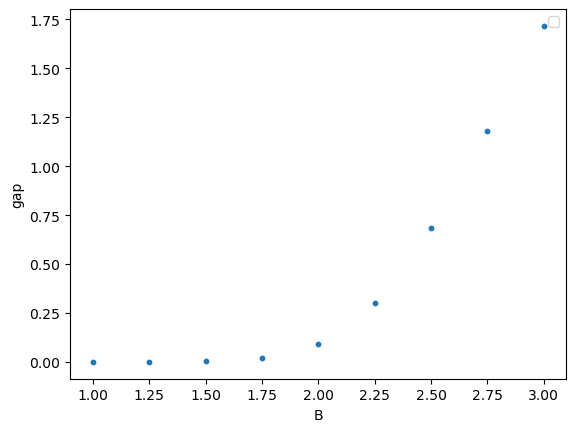

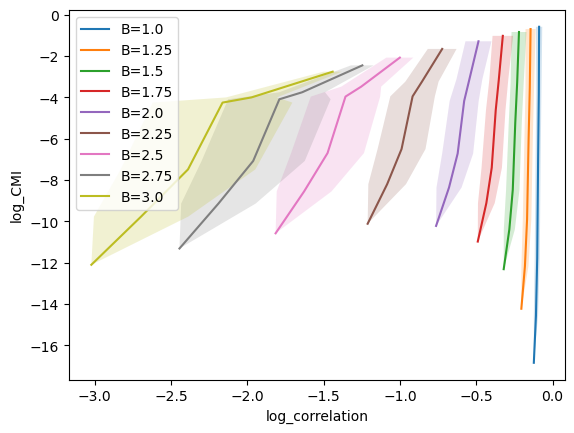

In [212]:
for i in B_:
    plt.plot(np.log(cmi[i]), label="B="+str(i))
plt.xlabel("distance")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/2DTFIM/cmi_2DTFIM_L"+str(L)+"periodic_"+str(periodic)+".png")
plt.show()

for i in B_:
    plt.plot(np.arange(len(mean_corr[i])-1)+1, np.log(mean_corr[i][1:]), label="B="+str(i))
    plt.fill_between(np.arange(len(mean_corr[i])-1)+1 ,np.log(mean_corr[i][1:]) - 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]) , np.log(mean_corr[i][1:]) + 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]), alpha=0.2)
plt.xlabel("distance")
plt.ylabel("log_correlation")
plt.legend()
plt.savefig("figure/2DTFIM/correlation_2DTFIM_L"+str(L)+"periodic_"+str(periodic)+".png")
plt.show()


plt.scatter(B_, gap.values(), s=10)
plt.xlabel("B")
plt.ylabel("gap")
plt.legend()
plt.savefig("figure/2DTFIM/gap_2DTFIM_L"+str(L)+"periodic_"+str(periodic)+".png")
plt.show()

for i in B_:
    plt.plot(np.log(mean_corr[i][1:]), np.log(cmi[i]), label="B="+str(i))
    plt.fill_betweenx(np.log(cmi[i]), np.log(mean_corr[i][1:]) - 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]) , np.log(mean_corr[i][1:]) + 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]), alpha=0.2)
plt.xlabel("log_correlation")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/2DTFIM/correlation_cmi_2DTFIM_L"+str(L)+"periodic_"+str(periodic)+".png")
plt.show()



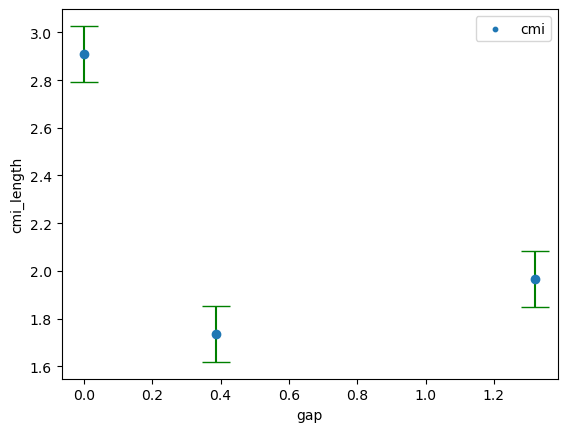

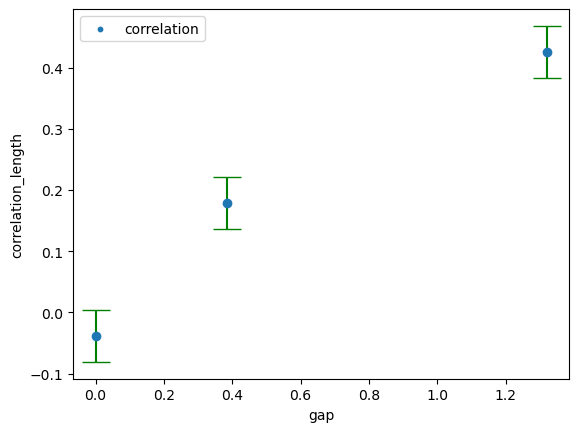

In [170]:

gap_list = []
for i in B_:
    gap_list.append(gap[i])

plt.scatter(gap_list, cmi_length, label="cmi", s=10)
plt.errorbar(gap_list, cmi_length, yerr=err_cmi_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("cmi_length")
plt.legend()
plt.savefig("figure/2DTFIM/cmi_length_gap_2DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".png")
plt.show()

plt.scatter(gap_list, corre_length, label="correlation", s=10)
plt.errorbar(gap_list, corre_length, yerr=err_corre_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("correlation_length")
plt.legend()
plt.savefig("figure/2DTFIM/correlation_length_gap_2DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".png")
plt.show()

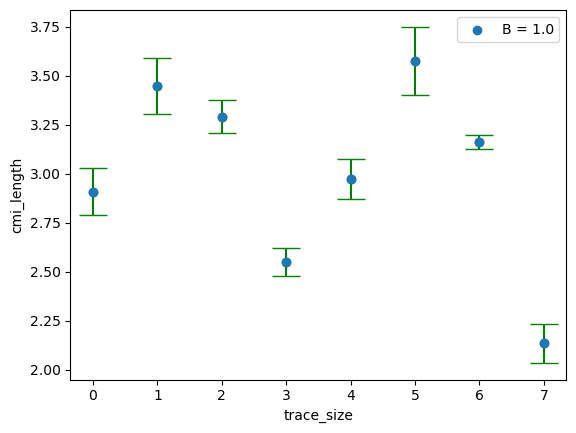

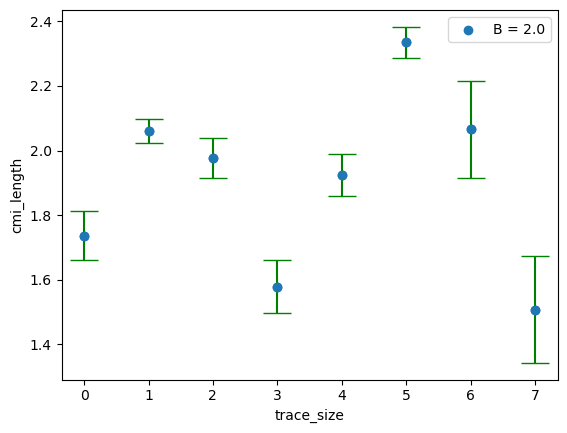

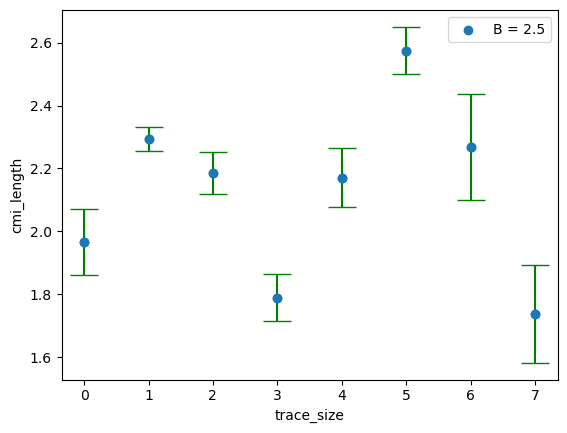

<Figure size 640x480 with 0 Axes>

In [180]:
for i in range(len(B_)):
    plt.scatter(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], label="B = "+str(B_[i]))
    plt.errorbar(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], yerr=np.array(err_cmi_length_traceout[i]).ravel(), fmt='o', ecolor='g', capthick=1, capsize=10)
    plt.xlabel("trace_size")
    plt.ylabel("cmi_length")
    plt.legend()
    plt.savefig("figure/2DTFIM/cmi_length_traceout_2DTFIM_L"+str(L)+"_B_"+str(B_[i])+"periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()